# Sheet 9

#### 1 Pretraining LLMs

##### (a) BERT
Additional possible pretraining tasks
- Text Span Filling (TSF): Instead of missing words, there are now missing contiguous sections of text (spans). 
    - Understand broader context
    - Helpful for e.g. anwering questions, or any other example where phrases/clauses are used.
- Sentence order prediction (SOP): Given contiguous sentences, predict their ordering.
    - Capture logical flow, and coherence between sentences
    - NSP can be 'gamed' by learning topical overlap, rather than sentence relationships, SOP overcomes this.
    


##### (b) GPT
Alternative pretraining to CLM
- Prefix Language Modelling (PLM): Given a prefix, this is randomly truncated, and model learns continuation.
    - Varying extent of prefix forces model to learn different levels of context
    - Attention to specific prefix required, helps improve generative text
    - Complexity: Only tokens following prefix need to be generated => same level of complexity as PLM
    - Parallelisation: Extra variation from truncation, but multiple samples with different truncation points can be processed in parallel.
- Bidirectional Context Generalisation (BCG): Given both left and right context, the model generates the missing central token. E.g. The cat ___ on the mat.
    - Encourages leveraging preceeding and succeeding context.
    - Combines causal nature of GPT with bidirectional reasoning
    - Complexity: Higher - need to process both left and right context
    - Parallelisation: Harder - relationship between tokens in missing span


## 2 Under the hood of LLMs: Llama 2.7B

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open("access_token.txt", "r") as f:
    access_token = f.read().strip()

model = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model, token=access_token, torch_dtype = torch.float16).to(device)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

In [ ]:
for id in range(5100, 5110):
    print(f"{id=}, {tokenizer.decode([id])}")   # Display 10 tokens from the tokenizer's vocabulary

print("\ntokenizer length:", len(tokenizer))    # Display the length of the tokenizer's vocabulary

sun_id = tokenizer.encode("sun", return_tensors="pt")[-1] # Get the last token of the "sun" encoding
print(f"\n{sun_id=}")

print(tokenizer.decode(sun_id)) # Display the token corresponding to the "sun" encoding (decoding the token)

emb = model.get_input_embeddings()(sun_id.to(device)) # Get the embedding of the "sun" token
print("embedding shape:", emb.shape)

id=5100, compet
id=5101, pair
id=5102, inglés
id=5103, Response
id=5104, Fig
id=5105, grad
id=5106, documentation
id=5107, cant
id=5108, appreci
id=5109, ån

tokenizer length: 32000

sun_id=tensor([   1, 6575])
<s> sun
embedding shape: torch.Size([2, 4096])


In [ ]:
sequence = "My favorite composer is"
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)
print(tokenizer.decode(model_inputs["input_ids"].tolist()[0])) # view tokenized input
with torch.no_grad():
    outputs = model(**model_inputs)

logits = outputs['logits'][0, -1, :] # Get the logits of the last token of the sequence
print("\nlogits shape:", logits.shape)

probabilities = torch.nn.functional.softmax(logits, dim=-1) # Compute the probabilities using softmax
top_k = 7
top_prob, top_ind = torch.topk(probabilities, top_k) # Get the top 7 probabilities and their indices

print("\nOutputs:\n")

for i in range(top_k):
    print(f"{tokenizer.decode(top_ind[i].tolist())}: {top_prob[i]:.2f}") # Print top 7 tokens and their probabilities

<s> My favorite composer is

logits shape: torch.Size([32000])

Outputs:

Moz: 0.25
Ch: 0.11
Be: 0.09
Ludwig: 0.08
Fr: 0.03
Wolfgang: 0.02
Ig: 0.02


In [ ]:
import regex as re

sequence = ""
model_inputs = tokenizer(sequence, return_tensors="pt").to(device) # Encode the empty sequence

generated_answer = ""
for _ in range(30): # Generate 30 tokens
    with torch.no_grad():
        outputs = model(**model_inputs) # Forward pass through the model
        logits = outputs['logits'][0, -1, :] # Get the logits of the last token of the sequence
        probabilities = torch.nn.functional.softmax(logits, dim=-1) # Compute the probabilities using softmax
        next_token_id = torch.argmax(probabilities).unsqueeze(0) # Get the token id with the highest probability
        model_inputs["input_ids"] = torch.cat([model_inputs["input_ids"], next_token_id.unsqueeze(0)], dim=-1) # Append the new token to the input sequence
    
    next_word = tokenizer.decode(next_token_id.tolist()) # Decode the new token
    next_word = re.sub(r"[^a-zA-Z0-9.?!]", "", next_word) # Remove special characters, just want readable text
    generated_answer += next_word # Append the new token to the answer
    generated_answer += " "     # Add a space after the token
    
    print(generated_answer) # Print generated text so far

Unterscheidung 
Unterscheidung zwischen 
Unterscheidung zwischen  
Unterscheidung zwischen  K 
Unterscheidung zwischen  K raft 
Unterscheidung zwischen  K raft  
Unterscheidung zwischen  K raft  und 
Unterscheidung zwischen  K raft  und  
Unterscheidung zwischen  K raft  und  K 
Unterscheidung zwischen  K raft  und  K raft 
Unterscheidung zwischen  K raft  und  K raft werk 
Unterscheidung zwischen  K raft  und  K raft werk  
Unterscheidung zwischen  K raft  und  K raft werk   
Unterscheidung zwischen  K raft  und  K raft werk    
Unterscheidung zwischen  K raft  und  K raft werk     
Unterscheidung zwischen  K raft  und  K raft werk     K 
Unterscheidung zwischen  K raft  und  K raft werk     K raft 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  K 
Unterscheidung zwische

Why is there no added text for some of the steps?

## 3 Flow-based modeling

### (a)

The CDF of $Y^\prime = CDF_Y^{-1}(X)$ is 

$$CDF_{Y^\prime}(y) = P(Y^\prime \leq y) = P(CDF_Y^{-1}(X) \leq y),$$

since CDF is a monotonically non-decreasing function, applying $CDF_Y(\cdot)$ to both sides of the inequality will give an equivalent inequality, i.e.

$$CDF_{Y^\prime}(y) = P(CDF_Y(Y^\prime) \leq CDF_Y(y))$$
$$ = P(X \leq CDF_Y(y)) = CDF_{X}(CDF_Y(y))$$

If X is a RV following a uniform distribution between 0 to 1, we have $CDF_X(x) = x$, therefore,

$$CDF_{Y^\prime}(y) = CDF_Y(y),$$

but $$ p_Y = \frac{\mathrm{d}}{\mathrm{d}y} CDF_Y(y) $$

$$ p_Y = P_{Y^\prime} $$

which means the pdf of $Y$ and $Y^\prime$ are identical.

### (b)

After computing $CDF_X(x)$ and $CDF_Y(y)$ we can solve for $g(x) = CDF^{-1}_Y(CDF(x))$, which maps the random variable X to Y

Compute CDF as integral of p

$$CDF_X(x) = \frac{1}{4}x^2\text{, } CDF_Y(y) = -\frac{1}{4}y^2 + y$$
$$ g(x) = 2(1 - \sqrt{1 - \frac{1}{4}x^2} )

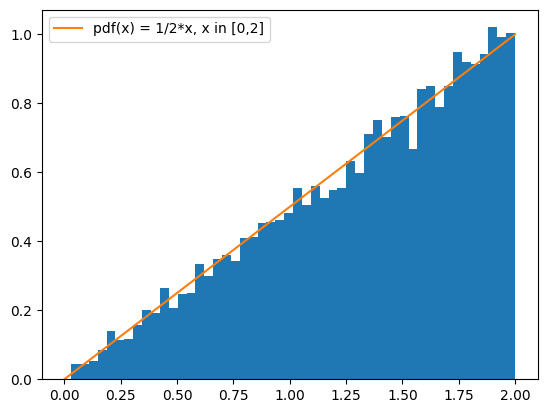

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load the 1d samples:
samples = np.load("data/samples_1d.npy")

x_lin = np.linspace(0, 2, 1000)
plt.hist(samples, bins=50, density=True)
plt.plot(x_lin, 1/2 * x_lin, label="pdf(x) = 1/2*x, x in [0,2]")
plt.legend()
plt.show()

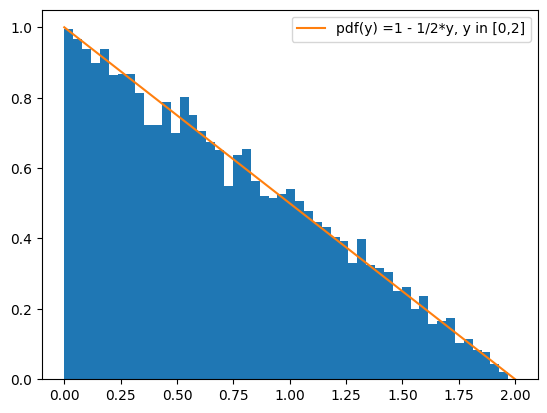

In [2]:
# TODO: transform the samples to samples from pdf(y) = -1/2*y + 1, y in [0,2]

# CDF(x) = 1/4 * x^2 
# CDF(y) = -1/4 * y^2 + y
# CDF_Y^-1(y') = 2 - 2*sqrt(1-y')

x_trans = 2 - 2 * np.sqrt(1 - 1/4 * samples**2)
plt.hist(x_trans, bins=50, density=True)
plt.plot(x_lin, -1/2 * x_lin + 1, label="pdf(y) =1 - 1/2*y, y in [0,2]")
plt.legend()
plt.show()

### (c)

Let $X_1, X_2 \sim U(0, 1)$, $Y_1, Y_2 \sim N^2(0, 1, 0, 1)$.

The pdf of $Y_1, Y_2$ is $$p_{{Y_1}, {Y_2}}(y_1, y_2) = \frac{1}{2\pi} \exp(-\frac{1}{2}(y_1^2 + y_2^2)).$$

Transform into polar coordinate $(r, \phi)$, gives 

$$Y_1 = R \cos \Phi,\ \  Y_2 = R \sin \Phi,$$
$$p_{R, \Phi}(r, \phi) = \frac{1}{2\pi} r\exp(-\frac{1}{2}r^2).$$

Corresponding marginal distribution, CDF and quantile function are given by
$$p(r) = \int_{0}^{2\pi} p_{R, \Phi}(r, \phi) \,d\phi, \ \ p(\phi) = \int_{0}^{\infty} p_{R, \Phi}(r, \phi) \,dr$$
$$p_R(r) = r\exp(-\frac{1}{2}r^2),\ \  p_{\Phi}(\phi) = \frac{1}{2\pi}$$
$$CDF_R(r) = 1 - \exp(-\frac{r^2}{2}),\ \  CDF_\Phi(\phi) = \frac{\phi}{2\pi}$$
$$CDF_R^{-1}(a) = \sqrt{-2\log(1-a)},\ \  CDF_\Phi^{-1}(b) = 2\pi b.$$

According to the result of (a) and (b), we have

$$R = CDF_R^{-1}(X_1) = \sqrt{-2\log(1-X_1)}, \ \ \Phi = CDF_\Phi^{-1}(X_2) = 2\pi X_2, $$
$$Y_1 = \sqrt{-2\log(1-X_1)} \cos (2\pi X_2),$$
$$Y_2 = \sqrt{-2\log(1-X_1)} \sin (2\pi X_2).$$

### (d)

Because different joint distribution could give same marginal distribution. The covariance of the multivariate distribution must be taken into account. Multivariate distributions also lack a complete natural ordering.

### (e)

If $h(x)$ is a monotonic function, then $h^{-1}(y)$ is also a monotonic function with same monotonicity.

The CDF of Y is 
$$
CDF_Y(y) = P(Y \leq y) = P(h(x) \leq y) 
= \left\{
    \begin{aligned}
    P(X \leq h^{-1}(y)),\ \  & h^\prime(x) \geq 0, \\
    P(X \geq h^{-1}(y)),\ \  & h^\prime(x) \leq 0.
    \end{aligned}\right.
$$

$$
CDF_Y(y) = \left\{
    \begin{aligned}
    CDF_X(h^{-1}(y)),\ \  & h^\prime(x) \geq 0, \\
    1 - CDF_X(h^{-1}(y)),\ \  & h^\prime(x) \leq 0.
    \end{aligned}\right.
$$

$$
p_Y(y) = \frac{d}{dy} CDF_Y(y) = \left\{
    \begin{aligned}
     \frac{p_X(h^{-1}(y))}{h^\prime(h^{-1}(y))},\ \  & h^\prime(x) \geq 0, \\
    - \frac{p_X(h^{-1}(y))}{h^\prime(h^{-1}(y))},\ \  & h^\prime(x) \leq 0.
    \end{aligned}\right.
$$

$$p_Y(y) = \left.p_X(x)\cdot|\frac{dh}{dx}(x)|^{-1}\right|_{x = h^{-1}(y)}$$